<a href="https://colab.research.google.com/github/Jodiedata/CTR_Prediction_XGboost/blob/master/CTR_Prediction_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Advertising Analytics CTR Prediction

Let’s assume that we are designing an algorithm for a search engine, and the task is to maximize revenue by displaying the best ads — ads that are both related to search results and are most likely to be clicked — at the top of the search results. How should we do it? <br>
As we know, the expected revenue (cost * click-probability) for the one ad would be higher than that of the other one, even though its dollar-cost is lower, because there is a higher chance that the user will click the first ad. In other words, we can look at the problem of maximizing revenue in terms of accurately predicting the probability that a given ad will be clicked i.e. “click-through rate” (CTR).

We will use the kaggle clicks data to build a model for CTR prediction. The links is here: https://www.kaggle.com/c/avazu-ctr-prediction/data

Our dataset comprises of the following features:

id: ad identifier<br>
click: 0 for non-click, 1 for click<br>
hour: in the format of YYMMDDHH<br>
C1: some anonymized categorical variable e.g. 1002<br>
banner_pos: where a banner is located, 1 and 0<br>
site_id: site identifier<br>
site_domain: hashed site domain<br>
site_category: hashed site category e.g. 28905ebd<br>
app_id: mobile app identifier<br>
app_domain<br>
app_category<br>
device_id: mobile device identifier<br>
device_ip: IP address<br>
device_model: hashed model e.g. iPhone 6, Samsung<br>
device_type: hashed device type e.g. tablet, smartphone<br>
device_conn_type: hashed type of connection e.g. Wi-Fi, 4G<br>
C14-C21: some more anonymized categorical variables<br>

#Content

* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
* [Part 4: Feature Selection](#Part-4:-Feature-Selection)

#Part 0. load packages, load data

In [ ]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta as timedelta
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

#A parse date variable to pass in the read_csv function later to take into account the date format 
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# A sample dataset of 100k lines.
!ls '/content/drive/My Drive/filtered_train'

df = pd.read_csv('/content/drive/My Drive/filtered_train.csv', parse_dates = ['hour'], date_parser = parse_date)

df.info()

df_clicks = df[df['click']==1]

ls: cannot access '/content/drive/My Drive/filtered_train': No such file or directory


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  app.launch_new_instance()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        404290 non-null  int64         
 1   id                404290 non-null  float64       
 2   click             404290 non-null  int64         
 3   hour              404290 non-null  datetime64[ns]
 4   C1                404290 non-null  int64         
 5   banner_pos        404290 non-null  int64         
 6   site_id           404290 non-null  object        
 7   site_domain       404290 non-null  object        
 8   site_category     404290 non-null  object        
 9   app_id            404290 non-null  object        
 10  app_domain        404290 non-null  object        
 11  app_category      404290 non-null  object        
 12  device_id         404290 non-null  object        
 13  device_ip         404290 non-null  object        
 14  devi

#Check missing values

In [ ]:
df.isnull().sum()

Unnamed: 0          0
id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

we don't need to worry about dealing missing data here.

#Part 1. Exploratory Data Analysis and Data Visualization

##Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        404290 non-null  int64         
 1   id                404290 non-null  float64       
 2   click             404290 non-null  int64         
 3   hour              404290 non-null  datetime64[ns]
 4   C1                404290 non-null  int64         
 5   banner_pos        404290 non-null  int64         
 6   site_id           404290 non-null  object        
 7   site_domain       404290 non-null  object        
 8   site_category     404290 non-null  object        
 9   app_id            404290 non-null  object        
 10  app_domain        404290 non-null  object        
 11  app_category      404290 non-null  object        
 12  device_id         404290 non-null  object        
 13  device_ip         404290 non-null  object        
 14  devi

In [ ]:
print(df.head())
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1])) # col count

   Unnamed: 0                       id  click                hour    C1  \
0      128037 11074508552284608512.000      0 2014-10-21 01:00:00  1005   
1      491755 12400122415769847808.000      0 2014-10-21 03:00:00  1005   
2      470924 10598011031664306176.000      0 2014-10-21 03:00:00  1005   
3      791624  1844218567631500288.000      0 2014-10-21 04:00:00  1005   
4      491263 12360159177072531456.000      1 2014-10-21 03:00:00  1005   

   banner_pos   site_id site_domain site_category    app_id app_domain  \
0           1  e151e245    7e091613      f028772b  ecad2386   7801e8d9   
1           0  1fbe01fe    f3845767      28905ebd  ecad2386   7801e8d9   
2           1  d9750ee7    98572c79      f028772b  ecad2386   7801e8d9   
3           1  856e6d3f    58a89a43      f028772b  ecad2386   7801e8d9   
4           1  d9750ee7    98572c79      f028772b  ecad2386   7801e8d9   

  app_category device_id device_ip device_model  device_type  \
0     07d7df22  a99f214a  10dcdfb1     8

In [ ]:
df['click'].describe()

count   404290.000
mean         0.170
std          0.375
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: click, dtype: float64

0   0.830
1   0.170
Name: click, dtype: float64

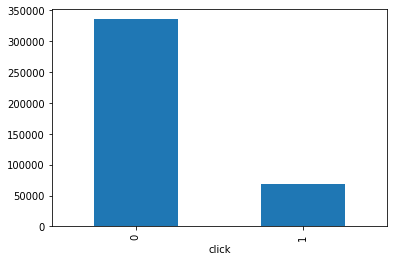

In [ ]:
# Click v/s No click distribution
df.groupby('click').size().plot(kind = 'bar')
rows = df.shape[0]
click_through_rate = df['click'].value_counts()/rows 
click_through_rate

17% of the data is with click == 1, meaning 17% of the ads are clicked.

##Histogram of categorical features

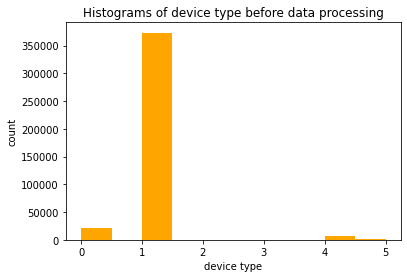

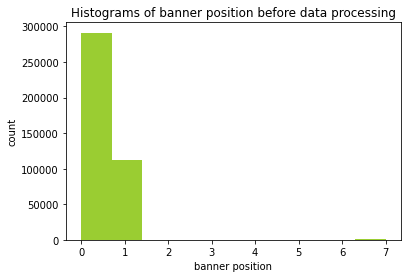

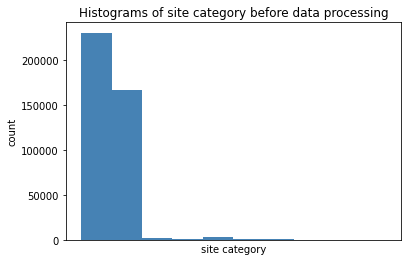

In [ ]:
plt.hist(x='device_type',data=df, color = 'orange')
plt.title('Histograms of device type before data processing')
plt.xlabel('device type')
plt.ylabel('count')
plt.show()

plt.hist(x='banner_pos',data=df, color = 'yellowgreen')
plt.title('Histograms of banner position before data processing')
plt.xlabel('banner position')
plt.ylabel('count')
plt.show()

plt.hist(x='site_category',data=df, color = 'steelblue')
plt.title('Histograms of site category before data processing')
plt.xlabel('site category')
plt.ylabel('count')
plt.xticks([])
plt.show()


We can see from the above graphs that the three categorical data is pretty skewed into several categories.

##Click-throughs and CTR of different categories

Define a function to show the click by category and CTR by category for multiple categorical features.

In [ ]:
sub_df = pd.crosstab(index = df['device_type'], columns = df['click']).reset_index()
sub_df.head()
sub_df.loc[(sub_df[1]==0) & (sub_df[0]==0),:]

click,device_type,0,1


In [ ]:
def show_graph(col):
    sub_df = pd.crosstab(index = df[col], columns = df['click']).reset_index()
    sub_df = sub_df.loc[(sub_df[1]!=0) & (sub_df[0]!=0),:]
    sub_df['CTR'] = sub_df[1]/(sub_df[0]+sub_df[1])
    sub_df[[0,1]].plot(kind='bar', stacked = True, figsize = (8,6))
    #plt.figure(figsize=(10,10))
    plt.title('Click by ' + col)
    plt.xlabel(col)
    plt.ylabel('count')
    #plt.show()
    print(sub_df[[col,'CTR']].sort_values(by='CTR',ascending = False).to_string(index = False))

 device_type   CTR
           0 0.217
           1 0.169
           4 0.095
           5 0.085


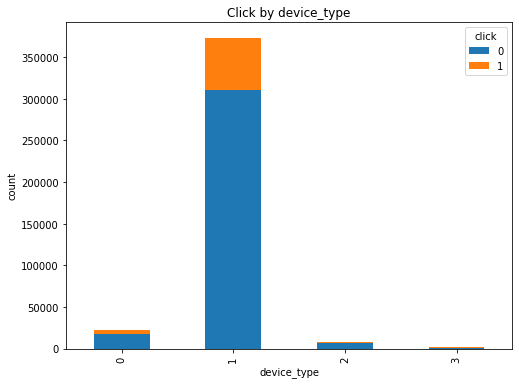

In [ ]:
show_graph('device_type')

If we compare the click ratios per device_type, we can see that there is a marked difference in the average click-through rate depending on device_type — highest click ratio is for device_type_0, 21.7%, and lowest is for device_type_5, 8.5%. This tells us that device_type is a good feature for predicting our target variable.

 banner_pos   CTR
          7 0.318
          3 0.250
          1 0.183
          4 0.174
          0 0.165
          2 0.108
          5 0.105


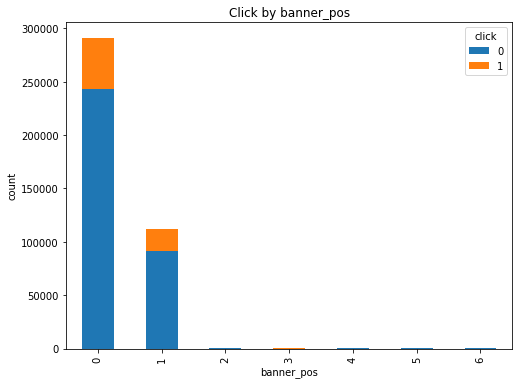

In [ ]:
show_graph('banner_pos')

Highest click ratio is for banner_position_7, 31.8%, and lowest is for banner_position_5, 10.5%.  Banner position with no click information has been excluded from this graph. This tells us that banner_position is a good feature for predicting our target variable.

site_category   CTR
     dedf689d 0.509
     5378d028 0.333
     3e814130 0.281
     42a36e14 0.243
     28905ebd 0.209
     f028772b 0.179
     70fb0e29 0.171
     50e219e0 0.129
     c0dd3be3 0.120
     75fa27f6 0.105
     72722551 0.091
     335d28a8 0.087
     f66779e6 0.046
     0569f928 0.037
     8fd0aea4 0.027
     76b2941d 0.021


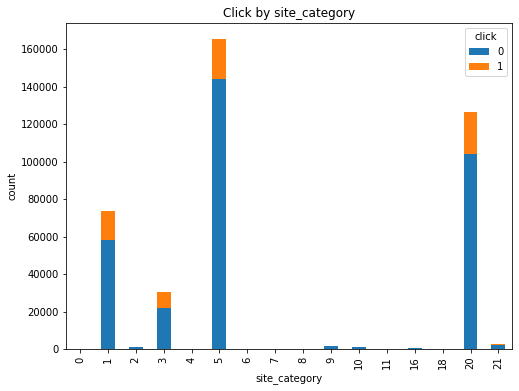

In [ ]:
show_graph('site_category')

Highest click ratio is for site_category _dedf689d, 50.9%, and lowest is for banner_position_76b2941d, 2.1%. Site category with no click information has been excluded from this graph. This tells us that banner_position is a good feature for predicting our target variable.<br>


app_category   CTR
    f95efa07 0.245
    8df2e842 0.238
    0f9a328c 0.208
    07d7df22 0.199
    4ce2e9fc 0.172
    09481d60 0.157
    dc97ec06 0.155
    d1327cf5 0.123
    879c24eb 0.117
    0f2161f8 0.107
    75d80bbe 0.103
    4681bb9d 0.096
    cef3e649 0.093
    8ded1f7a 0.092
    a86a3e89 0.053
    fc6fa53d 0.052
    a3c42688 0.047


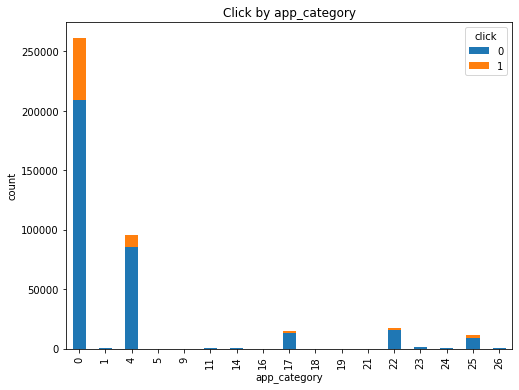

In [ ]:
show_graph('app_category')

Highest click ratio is for app_category _f95efa07, 24.5%, and lowest is for banner_position_a3c42688, 4.7%. App category with no click information has been excluded from this graph. This tells us that app_position is a good feature for predicting our target variable.<br>


##Date time features

In [ ]:
df['hour'].describe()

count                  404290
unique                    240
top       2014-10-22 09:00:00
freq                     4457
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

Text(0.5, 1.0, 'Clicks by hour of each day')

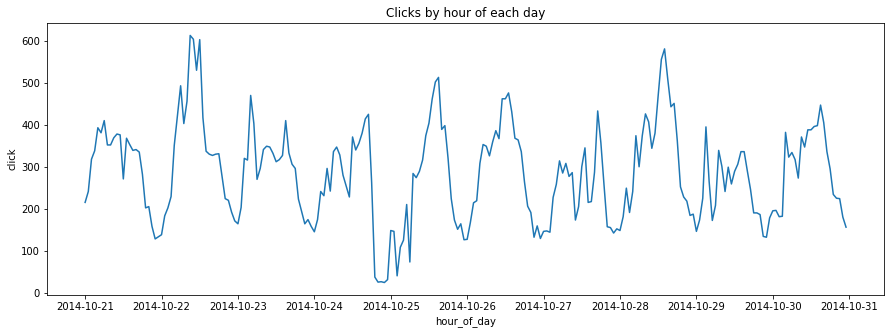

In [ ]:
#Plot the click by hour of each day
click_by_day = df[['hour','click']]
click_by_day = click_by_day.groupby('hour').sum().reset_index()
click_by_day.columns = ['hour_of_day','click']
plt.figure(figsize=(15,5))
sns.lineplot(x='hour_of_day', y='click', data=click_by_day)
plt.title('Clicks by hour of each day')
#xlabel = click_by_hour['hour'].apply(lambda x: x.date())
#plt.xlabel(xlabel)

The hourly clicks pattern looks pretty similar every day. However, there were a couple of peak hours, one is sometime in the mid of the day on Oct 22, and another is sometime in the mid of the day on Oct 28. And one very low click hour is close to mid-night on Oct 24.

Text(0.5, 1.0, 'Clicks by hour')

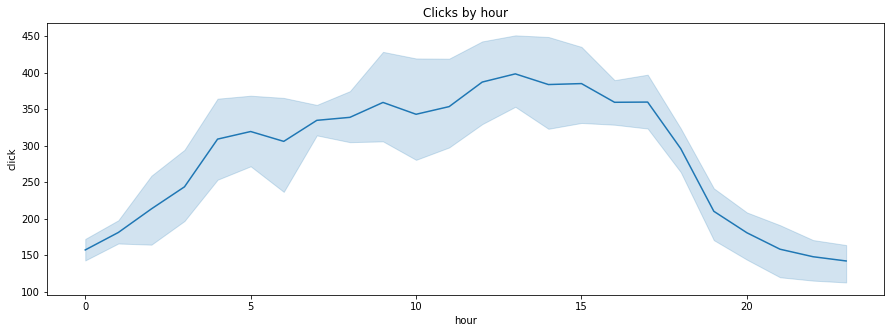

In [ ]:
#Plot the click by hour (aggregated by day)
click_by_hour = click_by_day.copy()
click_by_hour['hour'] = click_by_hour['hour_of_day'].apply(lambda x: x.hour)
#click_by_hour.columns = ['hour','click']
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='click', data=click_by_hour)
plt.title('Clicks by hour')

In general, the clicks increase in the morning and decrease till the midnight. The highest clicks are at 12pm or 1pm, and the lowest clicks are at 0am. 

 hour_   CTR
    15 0.184
     0 0.184
     1 0.182
     7 0.180
    16 0.177
    17 0.175
    14 0.175
    23 0.174
    12 0.174
     2 0.174
     3 0.173
     6 0.172
    11 0.172
    18 0.167
    13 0.167
    22 0.163
     5 0.163
     4 0.163
    21 0.162
    20 0.162
     8 0.161
    10 0.161
    19 0.159
     9 0.158


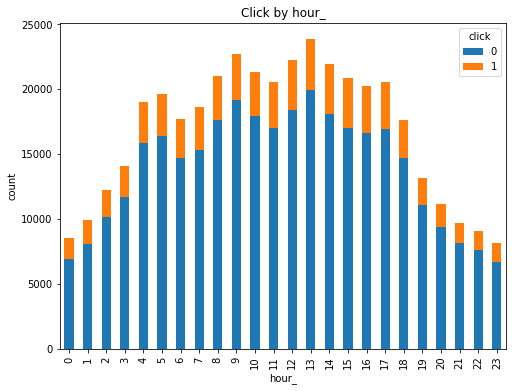

In [ ]:
df['hour_'] = df['hour'].apply(lambda x: x.hour)
show_graph('hour_')

Text(0.5, 1.0, 'Clicks by weekday')

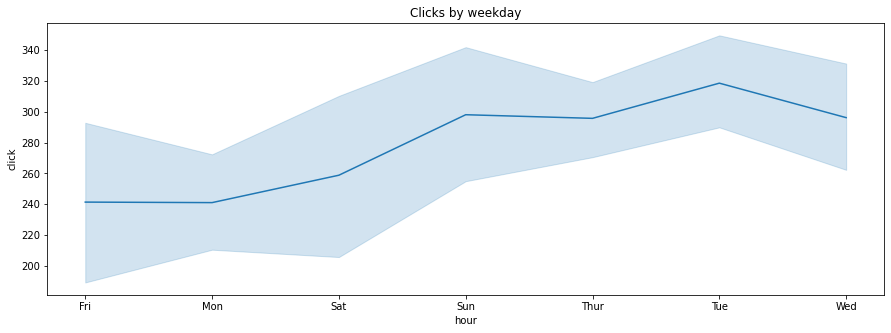

In [ ]:
#Clicks of week days
click_by_week = click_by_day.copy()
click_by_week['hour'] = click_by_week['hour_of_day'].apply(lambda x: x.dayofweek)
days_dic={0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
click_by_week['hour'] = click_by_week['hour'].map(days_dic)
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='click', data=click_by_week)
plt.title('Clicks by weekday')

In [ ]:
click_by_week.head(10)

,hour_of_day,click,hour,Impressions
0,2014-10-21 00:00:00,215,Tue,1
1,2014-10-21 01:00:00,241,Tue,1
2,2014-10-21 02:00:00,318,Tue,1
3,2014-10-21 03:00:00,338,Tue,1
4,2014-10-21 04:00:00,393,Tue,1
5,2014-10-21 05:00:00,381,Tue,1
6,2014-10-21 06:00:00,410,Tue,1
7,2014-10-21 07:00:00,352,Tue,1
8,2014-10-21 08:00:00,352,Tue,1
9,2014-10-21 09:00:00,369,Tue,1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Impressions by weekday')

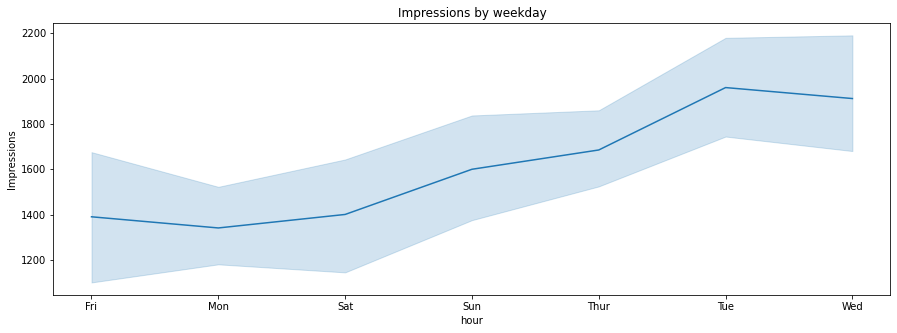

In [ ]:
#Impression of week days
click_by_week = df[['hour','click']]
click_by_week['Impressions'] = 1
click_by_week = click_by_week.groupby('hour').sum().reset_index()
click_by_week['hour'] = click_by_week['hour'].apply(lambda x: x.dayofweek)
days_dic={0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
click_by_week['hour'] = click_by_week['hour'].map(days_dic)
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='Impressions', data=click_by_week)
plt.title('Impressions by weekday')

Tuesdays have the most number of clicks and impressions, then Wednesdays, followed by Thursdays. Mondays and Fridays have the least number of clicks and impressions.

week_day   CTR
     Sun 0.186
     Sat 0.185
     Mon 0.180
    Thur 0.176
     Fri 0.174
     Tue 0.163
     Wed 0.155


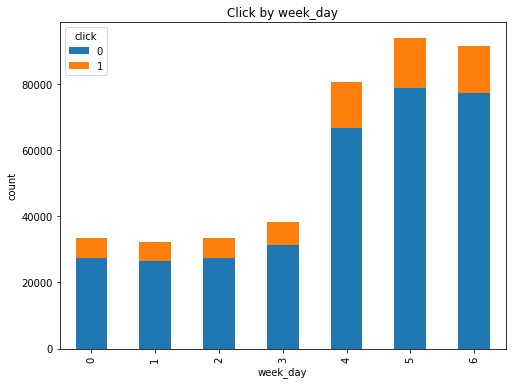

In [ ]:
df['week_day'] = df['hour'].apply(lambda x: x.dayofweek)
days_dic={0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
df['week_day']= df['week_day'].map(days_dic)
show_graph('week_day')

Sunday has the highest CTR, followed by Saturday and Monday, though their impressions and clicks are not the highest.

##Correlation between features

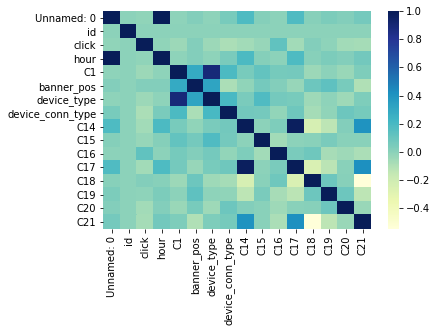

In [ ]:
pearson = df.corr(method='pearson')
# show heapmap of correlations
sns.heatmap(pearson,cmap="YlGnBu")

(1)The highest correlation is between C1, banner_pos, and device_type. It makes a lot sense that the banner position and device type are highly correlated.<br>
(2)We have negatively correlated variables - C18 and C21.<br>
(3) C16 is highly correlated with our target variable click. banner position and C18 are relately highly correlated with click too.<br>
(4)Id is not correlated with any of the features, which is what we expect to see.


#Part 2. Feature Engineering for XGboost and LightGBM model

##Hashing the categorical features

In [ ]:
Convert categorical features to numerical features, it can minimize the memory consumption by the features.

In [ ]:
click_by_week['hour'].dtypes

dtype('O')

In [ ]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] != int:
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
    
df_model = convert_obj_to_int(df)

In [ ]:
df_model.head(10)


,Unnamed: 0,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,id_int,hour_int,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int
0,128037,0,1005,1,1,0,20352,320,50,2333,0,39,-1,157,1851136515429832708,-5504914308411718190,3313200183633152470,-4740863942945760051,5536396786171021463,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-4585295244068350244,358576413308335100
1,491755,0,1005,0,1,0,15701,320,50,1722,0,35,100084,79,870907369701378053,6248454270083823517,-4982934931202804732,-6401314246411525770,9114451542737112072,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-1601265454233218854,-413330847822570983
2,470924,0,1005,1,1,0,17614,320,50,1993,2,1063,-1,33,1374638994809530372,6248454270083823517,-1846540141553495697,459317138989523756,5536396786171021463,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-7244720979837981716,689895388136294759
3,791624,0,1005,1,1,0,16208,320,50,1800,3,167,100075,23,1844218567631500288,-3652415584395688521,6284382993401260880,7654526404851795092,5536396786171021463,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-6627780091908111748,-7638054607217932975
4,491263,1,1005,1,1,0,17614,320,50,1993,2,1063,-1,33,830944131004061701,6248454270083823517,-1846540141553495697,459317138989523756,5536396786171021463,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-302178925910177771,5463420581279209704
5,836489,0,1005,1,1,0,16071,320,50,1784,2,175,100075,95,48387146170622978,-3652415584395688521,-3377829324121154603,8491856204138550781,5536396786171021463,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-2676602350507982318,-8534614955488446281
6,371403,0,1005,0,1,0,21647,320,50,2487,1,547,-1,51,294034695527424001,-5688538096583776976,-7052432531362548359,1907092293102099262,9140304770713661246,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-5755994773086828096,-6337595865414466446
7,73349,0,1005,0,1,2,18993,320,50,2161,0,35,-1,157,1293234696947051009,4240632564129425253,-1315251920760940429,-3584738422873482077,-505340801626743153,-8035372221721464921,-1108221301414773065,-8084641172719741920,-369447297597314522,5934830865583732438,-5892863911620884666
8,117583,1,1005,0,1,0,15705,320,50,1722,0,35,100084,79,578726218889777156,4240632564129425253,-4982934931202804732,-6401314246411525770,9114451542737112072,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,689668962012072635,689895388136294759
9,21440,0,1005,0,1,0,15708,320,50,1722,0,35,-1,79,1431651494640035845,4240632564129425253,-4982934931202804732,-6401314246411525770,9114451542737112072,-3557976943843515094,-4196694844799427527,7781118763427570549,-369447297597314522,-6942646890864231331,-2514868768036749745


##Train a XGboost Model

In [ ]:
from sklearn.model_selection import train_test_split
# Extracting all columns from the train model except the target mask column
model_target = 'click'
model_features = np.array(df_model.columns[df_model.columns!=model_target].tolist())

#Split the dataset
x_train, x_test, y_train, y_test = train_test_split(
    df_model[model_features].values,
    df_model[model_target].values,
    test_size=0.3,
)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    stratify=y_train,
    test_size=0.1)


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from operator import itemgetter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

#Build a XGBoost classifier
#Calculate the ratio of positive weight
data_dmatrix = xgb.DMatrix(data=df_model[model_features],label=df_model[model_target],feature_names=model_features)
label = data_dmatrix.get_label()
ratio = float(np.sum(label == 0)) / np.sum(label == 1)

xgb_clf = XGBClassifier(scale_pos_weight=ratio)
xgb_clf.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

[0]	validation_0-auc:0.620389
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.644658
[2]	validation_0-auc:0.654963
[3]	validation_0-auc:0.654352
[4]	validation_0-auc:0.658208
[5]	validation_0-auc:0.658945
[6]	validation_0-auc:0.661494
[7]	validation_0-auc:0.661976
[8]	validation_0-auc:0.663811
[9]	validation_0-auc:0.664124
[10]	validation_0-auc:0.664501
[11]	validation_0-auc:0.6647
[12]	validation_0-auc:0.665107
[13]	validation_0-auc:0.667862
[14]	validation_0-auc:0.670845
[15]	validation_0-auc:0.673467
[16]	validation_0-auc:0.673945
[17]	validation_0-auc:0.675325
[18]	validation_0-auc:0.676487
[19]	validation_0-auc:0.677574
[20]	validation_0-auc:0.677756
[21]	validation_0-auc:0.678106
[22]	validation_0-auc:0.679468
[23]	validation_0-auc:0.67955
[24]	validation_0-auc:0.680127
[25]	validation_0-auc:0.681013
[26]	validation_0-auc:0.681584
[27]	validation_0-auc:0.681761
[28]	validation_0-auc:0.682172
[29]	validation_0-auc:0.682889
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.888718957104363,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
#Define a function to print out evaluation metrics
def model_evaluation(model):  
    from sklearn.metrics import classification_report

    #Evaluate the initial model on training set
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    print(classification_report(y_test,
                            predictions))
    
    from sklearn.metrics import plot_confusion_matrix

    class_names = model_target

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
      disp = plot_confusion_matrix(model, x_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
      disp.ax_.set_title(title)

      print(title)
      print(disp.confusion_matrix)
    plt.show()

              precision    recall  f1-score   support

           0       0.91      0.59      0.72    100712
           1       0.26      0.71      0.39     20575

    accuracy                           0.61    121287
   macro avg       0.59      0.65      0.55    121287
weighted avg       0.80      0.61      0.66    121287

Confusion matrix, without normalization
[[59859 40853]
 [ 5920 14655]]
Normalized confusion matrix
[[0.59435817 0.40564183]
 [0.28772783 0.71227217]]


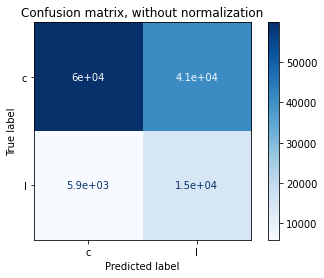

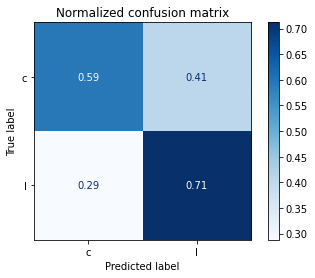

In [ ]:
model_evaluation(xgb_clf)

##Fine-tune the model

In [ ]:
#Set up initial classifier
xgb_clf_1 = XGBClassifier(base_score=0.6, 
                        booster='gbtree',
                        gamma=0.1,
                        colsample_bytree=0.8,
                        learning_rate=0.1, 
                        max_depth=5,
                        min_child_weight=1, 
                        n_estimators=1000, 
                        nthread=4, 
                        objective='binary:logistic', 
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=ratio,
                        seed=123,  
                        subsample=0.8, 
                        )

xgb_clf_1.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

[0]	validation_0-auc:0.66572
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.668638
[2]	validation_0-auc:0.681987
[3]	validation_0-auc:0.686207
[4]	validation_0-auc:0.690992
[5]	validation_0-auc:0.693375
[6]	validation_0-auc:0.693076
[7]	validation_0-auc:0.694073
[8]	validation_0-auc:0.693255
[9]	validation_0-auc:0.694626
[10]	validation_0-auc:0.693956
[11]	validation_0-auc:0.695568
[12]	validation_0-auc:0.696001
[13]	validation_0-auc:0.695989
[14]	validation_0-auc:0.697208
[15]	validation_0-auc:0.697465
[16]	validation_0-auc:0.698627
[17]	validation_0-auc:0.699121
[18]	validation_0-auc:0.699801
[19]	validation_0-auc:0.700726
[20]	validation_0-auc:0.700961
[21]	validation_0-auc:0.701359
[22]	validation_0-auc:0.701409
[23]	validation_0-auc:0.701576
[24]	validation_0-auc:0.70192
[25]	validation_0-auc:0.703035
[26]	validation_0-auc:0.703659
[27]	validation_0-auc:0.704071
[28]	validation_0-auc:0.7047
[29]	validation_0-auc:0.705225
[30]	validation_0-au

XGBClassifier(base_score=0.6, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.888718957104363,
              seed=123, silent=None, subsample=0.8, verbosity=1)

              precision    recall  f1-score   support

           0       0.92      0.62      0.74    100712
           1       0.28      0.72      0.40     20575

    accuracy                           0.64    121287
   macro avg       0.60      0.67      0.57    121287
weighted avg       0.81      0.64      0.68    121287

Confusion matrix, without normalization
[[62241 38471]
 [ 5696 14879]]
Normalized confusion matrix
[[0.61800977 0.38199023]
 [0.27684083 0.72315917]]


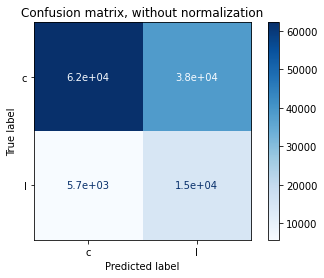

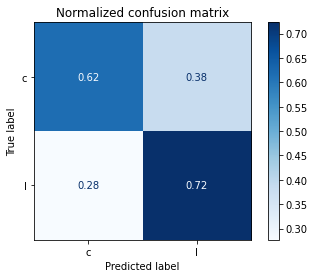

In [ ]:
model_evaluation(xgb_clf_1)

##Tune max_depth and min_weight

In [ ]:
param_test1 = {
 'max_depth':[3, 8],
 'min_child_weight':[3, 5]
}
gsearch1 = GridSearchCV(estimator = xgb_clf_1, 
                        param_grid = param_test1,     
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch1.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[0]	validation_0-auc:0.685665
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698645
[2]	validation_0-auc:0.701317
[3]	validation_0-auc:0.707474
[4]	validation_0-auc:0.708942
[5]	validation_0-auc:0.711087
[6]	validation_0-auc:0.710665
[7]	validation_0-auc:0.710709
[8]	validation_0-auc:0.710916
[9]	validation_0-auc:0.711771
[10]	validation_0-auc:0.711735
[11]	validation_0-auc:0.712012
[12]	validation_0-auc:0.712429
[13]	validation_0-auc:0.712698
[14]	validation_0-auc:0.712818
[15]	validation_0-auc:0.713049
[16]	validation_0-auc:0.713377
[17]	validation_0-auc:0.714044
[18]	validation_0-auc:0.714346
[19]	validation_0-auc:0.714663
[20]	validation_0-auc:0.71472
[21]	validation_0-auc:0.715161
[22]	validation_0-auc:0.715705
[23]	validation_0-auc:0.715819
[24]	validation_0-auc:0.716463
[25]	validation_0-auc:0.716677
[26]	validation_0-auc:0.717212
[27]	validation_0-auc:0.717524
[28]	validation_0-auc:0.71794
[29]	validation_0-auc:0.718223
[30]	validation_0-

AttributeError: ignored

In [ ]:
gsearch1.best_params_

{'max_depth': 8, 'min_child_weight': 3}

In [ ]:
param_test2 = {
 'max_depth':[5,8],
 'min_child_weight':[3,5]
}
gsearch2 = GridSearchCV(estimator = xgb_clf_1, 
                        param_grid = param_test2,     
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch2.fit(x_train, y_train, early_stopping_rounds=20,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[0]	validation_0-auc:0.685665
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.698645
[2]	validation_0-auc:0.701317
[3]	validation_0-auc:0.707474
[4]	validation_0-auc:0.708942
[5]	validation_0-auc:0.711087
[6]	validation_0-auc:0.710665
[7]	validation_0-auc:0.710709
[8]	validation_0-auc:0.710916
[9]	validation_0-auc:0.711771
[10]	validation_0-auc:0.711735
[11]	validation_0-auc:0.712012
[12]	validation_0-auc:0.712429
[13]	validation_0-auc:0.712698
[14]	validation_0-auc:0.712818
[15]	validation_0-auc:0.713049
[16]	validation_0-auc:0.713377
[17]	validation_0-auc:0.714044
[18]	validation_0-auc:0.714346
[19]	validation_0-auc:0.714663
[20]	validation_0-auc:0.71472
[21]	validation_0-auc:0.715161
[22]	validation_0-auc:0.715705
[23]	validation_0-auc:0.715819
[24]	validation_0-auc:0.716463
[25]	validation_0-auc:0.716677
[26]	validation_0-auc:0.717212
[27]	validation_0-auc:0.717524
[28]	validation_0-auc:0.71794
[29]	validation_0-auc:0.718223
[30]	validation_0-

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.6, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4.888718957104363,
                                     seed=123, silent=None, subsample=0.8,
                                     verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [8, 10], 'min_child_weight': [3, 5]},
             pre_dispatch='2*n_jobs', refit=True, retur

In [ ]:
gsearch2.best_params_

{'max_depth': 8, 'min_child_weight': 3}

##Tune gamma

In [ ]:
xgb_clf_2 = XGBClassifier(base_score=0.6, 
                        booster='gbtree',
                        gamma=0.1,
                        colsample_bytree=0.8,
                        learning_rate=0.1, 
                        max_depth=8,
                        min_child_weight=3, 
                        n_estimators=1000, 
                        nthread=4, 
                        objective='binary:logistic', 
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=ratio,
                        seed=123,  
                        subsample=0.8, 
                        )
param_test3 = {
 'gamma':[0,1,3,5],
}

gsearch3 = GridSearchCV(estimator = xgb_clf_2, 
                        param_grid = param_test3,     
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch3.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[0]	validation_0-auc:0.685669
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698648
[2]	validation_0-auc:0.701317
[3]	validation_0-auc:0.707475
[4]	validation_0-auc:0.708943
[5]	validation_0-auc:0.711088
[6]	validation_0-auc:0.710666
[7]	validation_0-auc:0.710708
[8]	validation_0-auc:0.710916
[9]	validation_0-auc:0.711771
[10]	validation_0-auc:0.711735
[11]	validation_0-auc:0.712012
[12]	validation_0-auc:0.712428
[13]	validation_0-auc:0.712694
[14]	validation_0-auc:0.712814
[15]	validation_0-auc:0.713047
[16]	validation_0-auc:0.713374
[17]	validation_0-auc:0.714043
[18]	validation_0-auc:0.714347
[19]	validation_0-auc:0.714668
[20]	validation_0-auc:0.714721
[21]	validation_0-auc:0.715136
[22]	validation_0-auc:0.715662
[23]	validation_0-auc:0.715759
[24]	validation_0-auc:0.716429
[25]	validation_0-auc:0.716664
[26]	validation_0-auc:0.71712
[27]	validation_0-auc:0.717407
[28]	validation_0-auc:0.717771
[29]	validation_0-auc:0.71813
[30]	validation_0-

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.6, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4.888718957104363,
                                     seed=123, silent=None, subsample=0.8,
                                     verbosity=1),
             iid=False, n_jobs=4, param_grid={'gamma': [0, 1, 3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scorin

In [ ]:
gsearch3.best_params_

{'gamma': 0}

##Tune subsample and colsample_bytree

In [ ]:
xgb_clf_3 = XGBClassifier(base_score=0.6, 
                        booster='gbtree',
                        gamma=0,
                        colsample_bytree=0.8,
                        learning_rate=0.1, 
                        max_depth=8,
                        min_child_weight=3, 
                        n_estimators=1000, 
                        nthread=4, 
                        objective='binary:logistic', 
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=ratio,
                        seed=123,  
                        subsample=0.8, 
                        )
param_test4 = {
 'subsample':[0.8,1],
 'colsample_bytree':[0.8,1]
}

gsearch4 = GridSearchCV(estimator = xgb_clf_3, 
                        param_grid = param_test4,     
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch4.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[0]	validation_0-auc:0.685669
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698648
[2]	validation_0-auc:0.701317
[3]	validation_0-auc:0.707475
[4]	validation_0-auc:0.708943
[5]	validation_0-auc:0.711088
[6]	validation_0-auc:0.710666
[7]	validation_0-auc:0.710708
[8]	validation_0-auc:0.710916
[9]	validation_0-auc:0.711771
[10]	validation_0-auc:0.711735
[11]	validation_0-auc:0.712012
[12]	validation_0-auc:0.712428
[13]	validation_0-auc:0.712694
[14]	validation_0-auc:0.712814
[15]	validation_0-auc:0.713047
[16]	validation_0-auc:0.713374
[17]	validation_0-auc:0.714043
[18]	validation_0-auc:0.714347
[19]	validation_0-auc:0.714668
[20]	validation_0-auc:0.714721
[21]	validation_0-auc:0.715136
[22]	validation_0-auc:0.715662
[23]	validation_0-auc:0.715759
[24]	validation_0-auc:0.716429
[25]	validation_0-auc:0.716664
[26]	validation_0-auc:0.71712
[27]	validation_0-auc:0.717407
[28]	validation_0-auc:0.717771
[29]	validation_0-auc:0.71813
[30]	validation_0-

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.6, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4.888718957104363,
                                     seed=123, silent=None, subsample=0.8,
                                     verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.8, 1], 'subsample': [0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
gsearch4.best_params_

{'colsample_bytree': 0.8, 'subsample': 0.8}

##Tune regularization term: reg_alpha

In [ ]:
xgb_clf_4 = XGBClassifier(base_score=0.6, 
                        booster='gbtree',
                        gamma=0,
                        colsample_bytree=0.8,
                        learning_rate=0.1, 
                        max_depth=8,
                        min_child_weight=3, 
                        n_estimators=1000, 
                        nthread=4, 
                        objective='binary:logistic', 
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=ratio,
                        seed=123,  
                        subsample=0.8, 
                        )
param_test5 = {
 'reg_alpa':[0,0.01,0.1,1],
}

gsearch5 = GridSearchCV(estimator = xgb_clf_4, 
                        param_grid = param_test5,     
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch5.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[0]	validation_0-auc:0.685669
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.698648
[2]	validation_0-auc:0.701317
[3]	validation_0-auc:0.707475
[4]	validation_0-auc:0.708943
[5]	validation_0-auc:0.711088
[6]	validation_0-auc:0.710666
[7]	validation_0-auc:0.710708
[8]	validation_0-auc:0.710916
[9]	validation_0-auc:0.711771
[10]	validation_0-auc:0.711735
[11]	validation_0-auc:0.712012
[12]	validation_0-auc:0.712428
[13]	validation_0-auc:0.712694
[14]	validation_0-auc:0.712814
[15]	validation_0-auc:0.713047
[16]	validation_0-auc:0.713374
[17]	validation_0-auc:0.714043
[18]	validation_0-auc:0.714347
[19]	validation_0-auc:0.714668
[20]	validation_0-auc:0.714721
[21]	validation_0-auc:0.715136
[22]	validation_0-auc:0.715662
[23]	validation_0-auc:0.715759
[24]	validation_0-auc:0.716429
[25]	validation_0-auc:0.716664
[26]	validation_0-auc:0.71712
[27]	validation_0-auc:0.717407
[28]	validation_0-auc:0.717771
[29]	validation_0-auc:0.71813
[30]	validation_0-

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.6, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4.888718957104363,
                                     seed=123, silent=None, subsample=0.8,
                                     verbosity=1),
             iid=False, n_jobs=4, param_grid={'reg_alpa': [0, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [ ]:
gsearch5.best_params_

{'reg_alpa': 0}

##Tune scale_pos_weight

In [ ]:
xgb_clf_5 = XGBClassifier(base_score=0.6, 
                        booster='gbtree',
                        gamma=0,
                        colsample_bytree=0.8,
                        learning_rate=0.1, 
                        max_depth=8,
                        min_child_weight=3, 
                        n_estimators=1000, 
                        nthread=4, 
                        objective='binary:logistic', 
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        seed=123,  
                        subsample=0.8, 
                        )
param_test6 = {
 'scale_pos_weight':[1,2,3,ratio],
}

gsearch6 = GridSearchCV(estimator = xgb_clf_5, 
                        param_grid = param_test6,     
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=3)

gsearch6.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[0]	validation_0-auc:0.692199
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.700611
[2]	validation_0-auc:0.706875
[3]	validation_0-auc:0.708878
[4]	validation_0-auc:0.709537
[5]	validation_0-auc:0.71169
[6]	validation_0-auc:0.711912
[7]	validation_0-auc:0.712501
[8]	validation_0-auc:0.712955
[9]	validation_0-auc:0.713429
[10]	validation_0-auc:0.713505
[11]	validation_0-auc:0.713764
[12]	validation_0-auc:0.714128
[13]	validation_0-auc:0.714413
[14]	validation_0-auc:0.714826
[15]	validation_0-auc:0.715044
[16]	validation_0-auc:0.715338
[17]	validation_0-auc:0.715422
[18]	validation_0-auc:0.71546
[19]	validation_0-auc:0.715722
[20]	validation_0-auc:0.715522
[21]	validation_0-auc:0.715742
[22]	validation_0-auc:0.716294
[23]	validation_0-auc:0.716864
[24]	validation_0-auc:0.717436
[25]	validation_0-auc:0.717834
[26]	validation_0-auc:0.718232
[27]	validation_0-auc:0.718522
[28]	validation_0-auc:0.718378
[29]	validation_0-auc:0.718506
[30]	validation_0-

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.6, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=123, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'scale_pos_weight': [1, 2, 3, 4.888718957104363]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', ve

In [ ]:
gsearch6.best_params_

{'scale_pos_weight': 1}

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    100712
           1       0.60      0.06      0.12     20575

    accuracy                           0.83    121287
   macro avg       0.72      0.53      0.51    121287
weighted avg       0.80      0.83      0.77    121287

Confusion matrix, without normalization
[[99826   886]
 [19254  1321]]
Normalized confusion matrix
[[0.99120264 0.00879736]
 [0.93579587 0.06420413]]


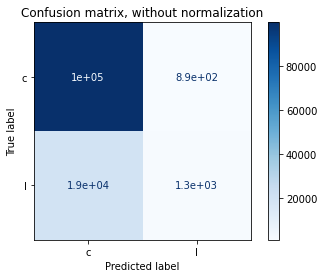

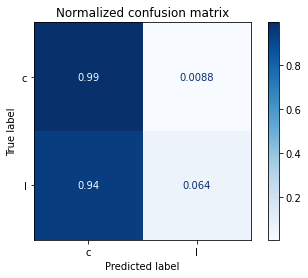

In [ ]:
#Evaluate the model with best parameters
model_evaluation(gsearch6)

Althoug the ovearll model performance measured by AUC is high, the precision and recall of predicting positive label are pretty low. Since the dataset is very imbalanced, we will set the scale_pos_weight back to the ratio (negative count/positive count) to maintain the model performace of predicting both positive and negative labels.<br>
This makes a lot sense if we think the problem this way: we would love to find the ads that can generate high CTR to increase our total revenue, if the model is bad at predicting the positive clicks, we will potentially be losing great business.

              precision    recall  f1-score   support

           0       0.92      0.62      0.74    100712
           1       0.28      0.72      0.40     20575

    accuracy                           0.64    121287
   macro avg       0.60      0.67      0.57    121287
weighted avg       0.81      0.64      0.68    121287

Confusion matrix, without normalization
[[62762 37950]
 [ 5764 14811]]
Normalized confusion matrix
[[0.62318294 0.37681706]
 [0.28014581 0.71985419]]


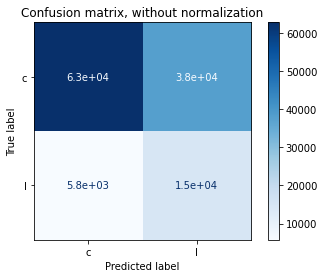

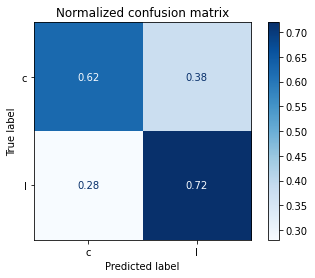

In [ ]:
#The best model
xgb_best = gsearch5
model_evaluation(xgb_best)

Based on confusion matrix, the model will be able recognize 72% of the ads that generates clicks, and 62% ads that can not generate clicks.